# Breakthrough model 1


author: bebu

date: 18.09.2025

description: Simple model to calculate the spacial (1D) co2 concentration in a breakthrough column (in air flow direction) and over time. All values are calculated per squaremeter of inlet area. Assumptions this model relies on:
- air flow in equals air flow out (i.e. the amound of co2 molecules being taken up in the column is neglegitable compared to the total amount of air molecules)
- the mass transfer coefficient (MTC) K_initial [mmol/(m^2 s kPa)] stays constant throughout time (i.e. it does not change with loading OR loading is constant throughout time as it would be in continuous operation.)

## Imports & Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
import time
import pandas as pd

def K_eff(uptake, K_initial, cap, V_liq):
    """Calculate effective mass transfer coefficient based on current uptake.
    
    Args:
        uptake (float): Current uptake in mol.
        K_initial (float): Initial mass transfer coefficient in mmol/(m^2 s kPa).
        cap (float): Cyclic uptake capacity in mol/L.
        V_liq (float): Liquid sorbent volume in L.
        N (int): Number of sections in the column.
        
    Returns:
        float: Effective mass transfer coefficient in mmol/(m^2 s kPa).
    """
    if uptake >= cap * V_liq:
        return 0.0
    else:
        return K_initial * (1 - uptake / (cap * V_liq))
    

def plot_model_results(x, n2l, l, v, SSA, dt, ds, save_path=""):
    # Custom colormap
    cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])
    l_N = l / n2l.shape[1] # l/ N
    p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
    
    # --- Figure with GridSpec: 3 rows, 2 cols ---
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(4, 3, width_ratios=[20, 1, 1], height_ratios=[2, 1, 2, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])          # full heatmap
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # tail heatmap
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)  # tail heatmap
    cax = fig.add_subplot(gs[:, 1])          # colorbar (shared)
    cax2 = fig.add_subplot(gs[:, 2])          # colorbar uptake (shared)
    
    # --- Top: full heatmap ---
    im = ax1.imshow(
        x[:,p-1:].T * 10, 
        cmap="Reds", vmin=0, vmax=400,
        interpolation="nearest", origin="lower", aspect="auto",
    
    )
    ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
    ax1.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax1.set_xticks(np.arange(x.shape[0]))                       # ticks at 0..N-1
    ax1.set_xticklabels(np.arange(1, x.shape[0] + 1))           # labels 1..N
    ax1.locator_params(axis="x", nbins=6)  # at most 6 ticks
    
    # --- Middle: outlet + CF ---
    line1, = ax2.plot(x[:, -1]*10, color="black", label="outlet CO$_2$")
    ax2.set_ylabel("outlet CO$_2$\n[ppm]", color="black")
    
    ax2b = ax2.twinx()
    cf = (400 - x[:, -1]*10) / 4
    line2, = ax2b.plot(cf, color="red", label="CF")
    ax2b.set_ylabel("CF [%]", color="red")
    
    ax2.tick_params(axis='y', colors=line1.get_color())
    ax2b.tick_params(axis='y', colors=line2.get_color())
    
    # --- Bottom middle: tail heatmap ---
    im2 = ax3.imshow(
        n2l[:, :].T/dt,
        cmap="Greens", vmin=0, vmax=(n2l/dt).max(),
        interpolation="nearest", origin="lower", aspect="auto"
    )
    ax3.set_title(f"uptake")
    ax3.set_xlabel(f"time (x {dt} s)")
    ax3.set_ylabel(f"tail section (segment {p} onward)\n{l_N} m each")
    ax3.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax3.set_yticks(np.arange(n2l.shape[1]))                       # ticks at 0..N-1
    ax3.set_yticklabels(np.arange(1, n2l.shape[1] + 1))           # labels 1..N
    ax3.locator_params(axis="y", nbins=6)  # at most 6 ticks
    
    line3, = ax4.plot(np.sum(n2l/dt*1000, axis=1), color="green", label="outlet CO$_2$")
    ax4.set_ylabel(f"instant. uptake\n[mmol/s]", color="green")
    
    ax4b = ax4.twinx()
    n_total = integrated = np.cumsum(np.sum(n2l, axis=1))
    line4, = ax4b.plot(n_total, color="black", label="cum. uptake")
    ax4b.set_ylabel("cum. uptake\n[mol]", color="black")
    #
    ax4.tick_params(axis='y', colors=line3.get_color())
    ax4b.tick_params(axis='y', colors=line4.get_color())
    
    # --- Shared colorbar ---
    fig.colorbar(im, cax=cax, label=f"gas phase CO$_2$ concentration [ppm]")
    fig.colorbar(im2, cax=cax2, label=f"uptake of co2 [mol/s] (per $m^2$ inlet area)")
    
    plt.tight_layout()

    if save_path != "":
        plt.savefig(save_path)
        print("saved plot as: " + save_path)

    plt.show()

def run_model(
        K_initial, 
        l, 
        SSA, 
        v, 
        dt, 
        N, 
        T, 
        eps=0.8, # wetting efficiency element [0, 1]
        ):
    # derived parameters
    l_N = l/N # length of one section [m]
    V_N = l_N # volume of one section [m^3]
    ds = v * dt / l_N # number of sections (that air travels in one time step)
    ds_int_flag = ds.is_integer() # flag if ds is integer
    #p = 2 # number of sections before inlet (for airspeeds larger than l_N/dt) -> could be set to np.ceil(ds)
    p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
    if ds_int_flag:
        print(f"ds = {ds} is integer.")
    print(f"ds: {ds} [segments per timesteps], -> p: {p} [segments before inlet]")

    # concentration matrix
    x = np.ones((T, N+p)) * np.nan # [Pa]. rows: time steps; collumns: sections

    # set initial and boundary conditions: 
    # 1) x = 40 Pa for all time steps(=rows) at inlet (p initial sections=columns);
    x[:, 0:p] = 40 # initial concentration in inlet [Pa]
    # 2) x = 40 Pa at t=0 for all sections:columns
    x[0, :] = 40 # initial concentration in collumn [Pa]
    x

    # mol in gase phase matrix (mol per time step and section)
    n = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections
    # uptake matrix (mol per time step and section)
    n2l = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections

    # total uptake (over time)
    n_total_t = np.zeros(T) # total uptake per time step [mol]
    for t in range(0, T):
        #print(f"t = {t}")
        # 1) calculate uptake n for section i at time step t
        n2l[t, :] = x[t,p:N+p] * eps * K_initial * 1e-6 * SSA * l_N * dt # uptake gas molecules to liquid [mol]
        #print(f"n2l = {n2l}")
        n[t, :] = x[t,p:N+p] * V_N / (8.314 * 298) - n2l[t, :]# remaining in gas phase [mol]
        if (n[t, :] < 0.0).any(): # check if remaining in gas phase is negative
            print(f"Warning: negative remaining in gas phase! setting to zero. time step: {t}, index: {np.where(n[t, :] < 0.0)}")
            n2l[t, n[t, :] < 0.0] = x[t,p:N+p][n[t, :] < 0.0] * V_N / (8.314 * 298) # limit uptake to remaining in gas phase
            n[t, n[t, :] < 0.0] = 0.0
        #n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt * 44 # uptake [g_co2]

        # 2) calc remaining concentration after uptake:
        x[t, p:N+p] = n[t, :] * 8.314 * 298 / (V_N) # new concentration [Pa]
        #print(f"calculated remaind partial pressure in gasphase (at end of timestep {t}): {x[t, p:N+p]}")

        if t < T - 1:
            # 3) calc next concentration x for all sections (p:N+p) at time step t+1
            if ds_int_flag:# if ds is int(ds)
                x[t+1, p:N+p] = x[t, (p-int(ds)):(N+p-int(ds))] # new concentration (in next time step) equals the one in segment ds (integer) steps back (in this timestep)
            else: 
                x[t+1, p:N+p] = x[t, (p-int(np.floor(ds))):(N+p-int(np.floor(ds)))]*(np.ceil(ds) - ds) + x[t, (p-int(np.ceil(ds))):(N+p-int(np.ceil(ds)))]*(ds - np.floor(ds)) # new concentration (in next time step) equals a mix of the concentation in the two segments that are ceil(ds) and floor(ds) steps back
    
    return x, n2l, n, ds

In [2]:
# parameter recommendation: dt < 1e6/(RT K eps SSA) = ca 
1e6/(8.314*300*1.5*0.8*210)

1.5909926903431835

## Set parameter, run model

Running simulation for 2 seconds. [model parameter: Npm=100; dt=0.001 s]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=46.36%; inst. uptake=7.48mmol/second


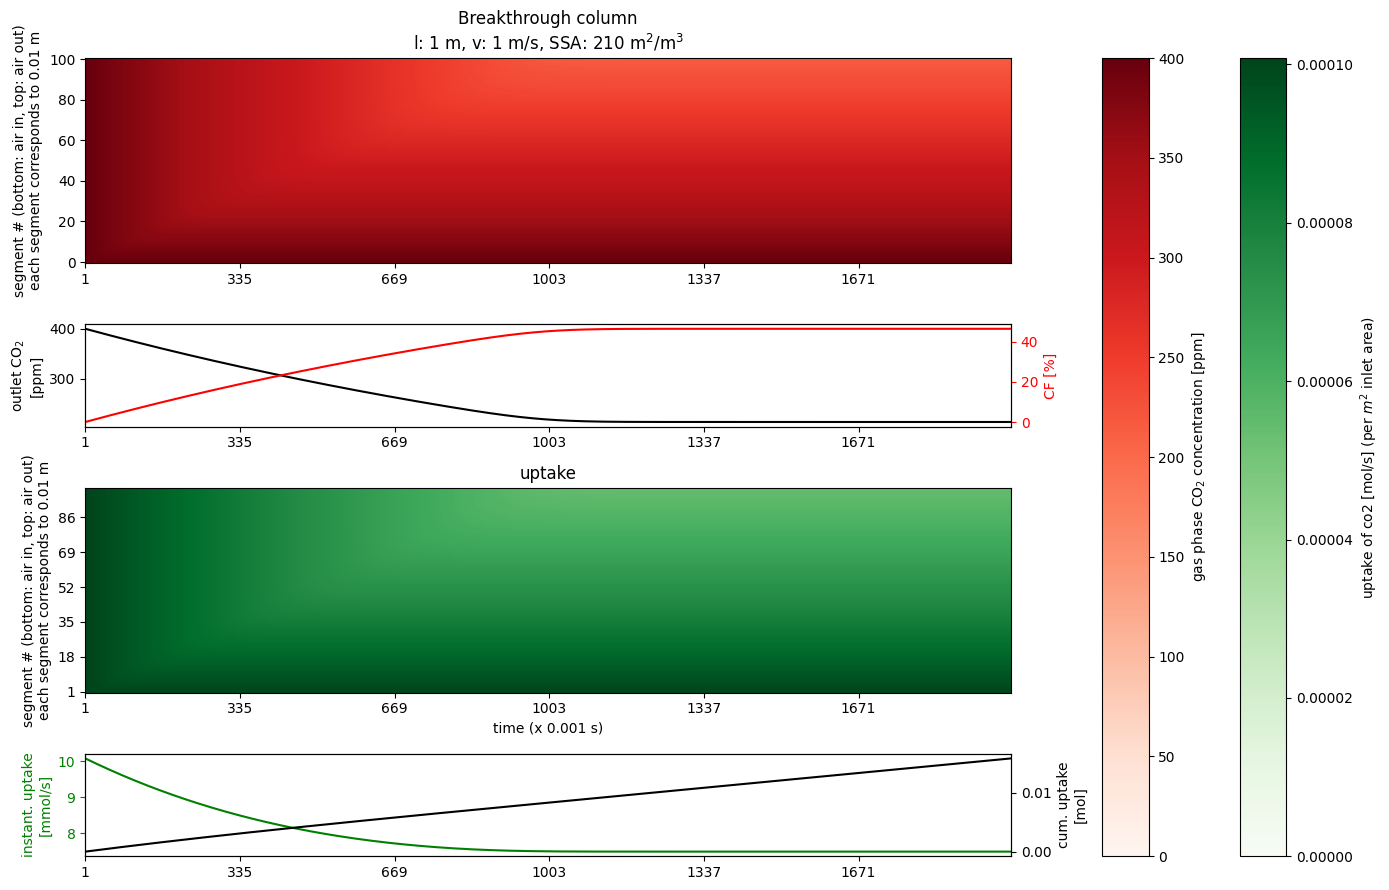

In [3]:
# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 1 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

# model parameters
dt = 0.001 # time step [s]
Npm = 100 # number of sections per meter
N = int(Npm * l) # number of sections in the collumn
duration = 2 # s
T = int(duration/dt) # total simulation time steps

print(f"Running simulation for {duration} seconds. [model parameter: Npm={Npm}; dt={dt} s]")

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep

print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]/dt *1000:.3g}mmol/second")
plot_model_results(x, n2l, l, v, SSA, dt, ds)

Running simulation for 3 seconds. [model parameter: Npm=100; dt=0.001 s]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=71.22%; inst. uptake=11.5mmol/second
saved plot as: model_results\model1\model1p0_run_03


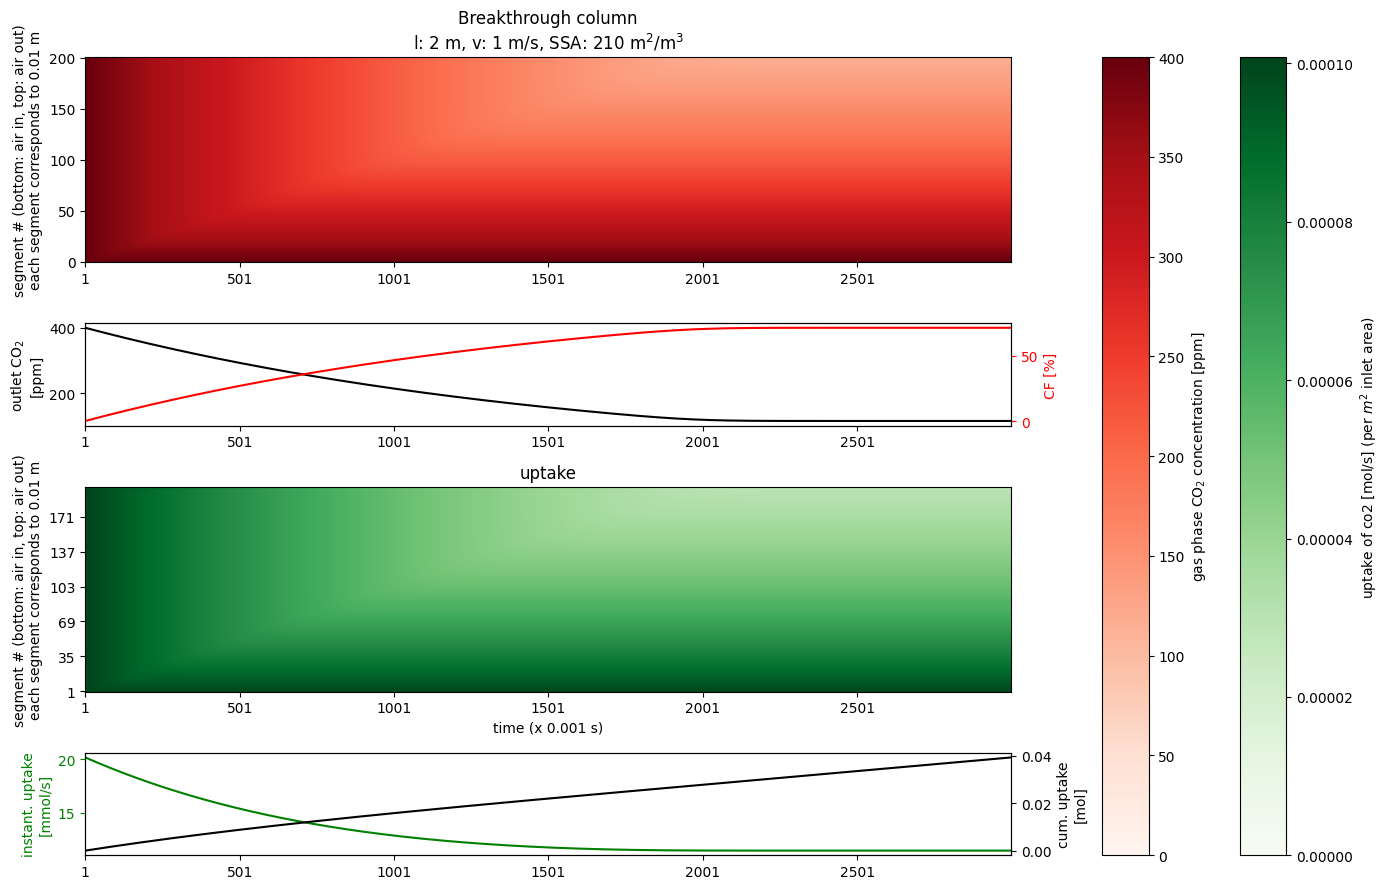

In [4]:
# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 2 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

# model parameters
dt = 0.001 # time step [s]
Npm = 100 # number of sections per meter
N = int(Npm * l) # number of sections in the collumn
duration = 3 # s
T = int(duration/dt) # total simulation time steps

print(f"Running simulation for {duration} seconds. [model parameter: Npm={Npm}; dt={dt} s]")

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
# check if cf's are equal up to rtol=0.1% (for individual entries):
# consecutive-row differences
#diff = np.abs(cf[1:] - cf[:-1])
# per-entry condition: |Δ| ≤ rtol*|prev| 
#same_row_follows_mask = diff <= 0.0001 * np.abs(cf[:-1])

inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
#if np.any(same_row_follows_mask):
#    first_row = np.argmax(same_row_follows_mask) # first row that is steady state
#    #print("run reached STEADY STATE! (i.e. concentation in setup equal over last 2 timesteps)")
#    #print(f"First steady state timestep is {first_row + 1} (equal to timestep {first_row+2})")
#    if not np.all(same_row_follows_mask[first_row:]): 
#        raise ValueError("Not all rows are equal after first steady state...")
#    print(f"STEADY STATE: CF={cf[first_row]:.2f}%; inst. uptake={inst_uptake[first_row]:.3g}mol/timestep; first steady state timestep: {first_row + 1}")
#else:
#    print("Warning: run did not reach steady state. (i.e. concentation in setup NOT equal over last 2 timesteps)")
print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]/dt *1000:.3g}mmol/second")
plot_model_results(x, n2l, l, v, SSA, dt, ds, save_path=r"model_results\model1\model1p0_run_03")

## Validation 
check that final CF and inst. uptake converge over model parameter. check effect of model parameter on calculaiton time.

In [5]:
# --------------------------
# Parameter sweep definition
# --------------------------
Npm_list = [1, 10, 100, 1000]
#Npm_list = [1, 2]
dt_list  = [1.0, 0.1, 0.01, 0.001, 0.0001]  # kept as given (includes duplicate 0.001)
#dt_list  = [1.0, 0.1]  # kept as given (includes duplicate 0.001)
path = r"model_results\model1\df_model1p0_validation_03"

# --------------------------
# Fixed/problem parameters (edit if needed)
# --------------------------
duration = 3.0  # [s]
eps = 0.8       # wetting efficiency [-]

# Assumes these exist in your environment (as in your example):
# K_initial, l, SSA, v, run_model(...)

results = []

for Npm in Npm_list:
    for dt in dt_list:
        N = int(Npm * l)                     # number of axial sections
        T = int(duration / dt)               # number of timesteps

        # --- time the model execution
        t0 = time.perf_counter()
        x, n2l, n, ds = run_model(
            # sorbent
            K_initial=K_initial,          # [mmol/(m^2 s kPa)]
            # process design
            l=l,                          # [m]
            SSA=SSA,                      # [m^2/m^3]
            # operation
            v=v,                          # [m/s]
            eps=eps,                      # [-]
            # model
            N=N,                          # [-]
            T=T,                          # [-]
            dt=dt                         # [s]
        )
        t1 = time.perf_counter()
        calc_time = t1 - t0

        # --- metrics
        # capture fraction at final time step (your definition)
        cf = (400 - x[:, -1] * 10) / 4             # (%) per section
        cf_last = cf[-1] if cf.ndim == 1 else np.asarray(cf).ravel()[-1]

        # instantaneous uptake: sum over species (?) per timestep; last timestep, then /dt
        inst_uptake = np.sum(n2l, axis=1)          # shape (T,)
        inst_uptake_rate_last = inst_uptake[-1] / dt

        results.append({
            "Npm": Npm,
            "dt": dt,
            "N": N,
            "T": T,
            "calc_time_s": calc_time,
            "inst_uptake_last_over_dt": inst_uptake_rate_last,
            "cf_last_percent": cf_last
        })

# --------------------------
# Collect results
# --------------------------
df = pd.DataFrame(results).sort_values(["dt", "Npm"]).reset_index(drop=True)
print(df)


df.to_csv(path)
print("saved result df to: " + path)



ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.01 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.001 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.0001 [segments per timesteps], -> p: 1 [segments before inlet]
ds = 10.0 is integer.
ds: 10.0 [segments per timesteps], -> p: 10 [segments before inlet]
ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.09999999999999999 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.01 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.001 [segments per timesteps], -> p: 1 [segments before inlet]
ds = 100.0 is integer.
ds: 100.0 [segments per timesteps], -> p: 100 [segments before inlet]
ds = 10.0 is integer.
ds: 10.0 [segments per timesteps], -> p: 10 [segments before inlet]
ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [se

saved plot as: model_results\model1\df_model1p0_validation_03.png


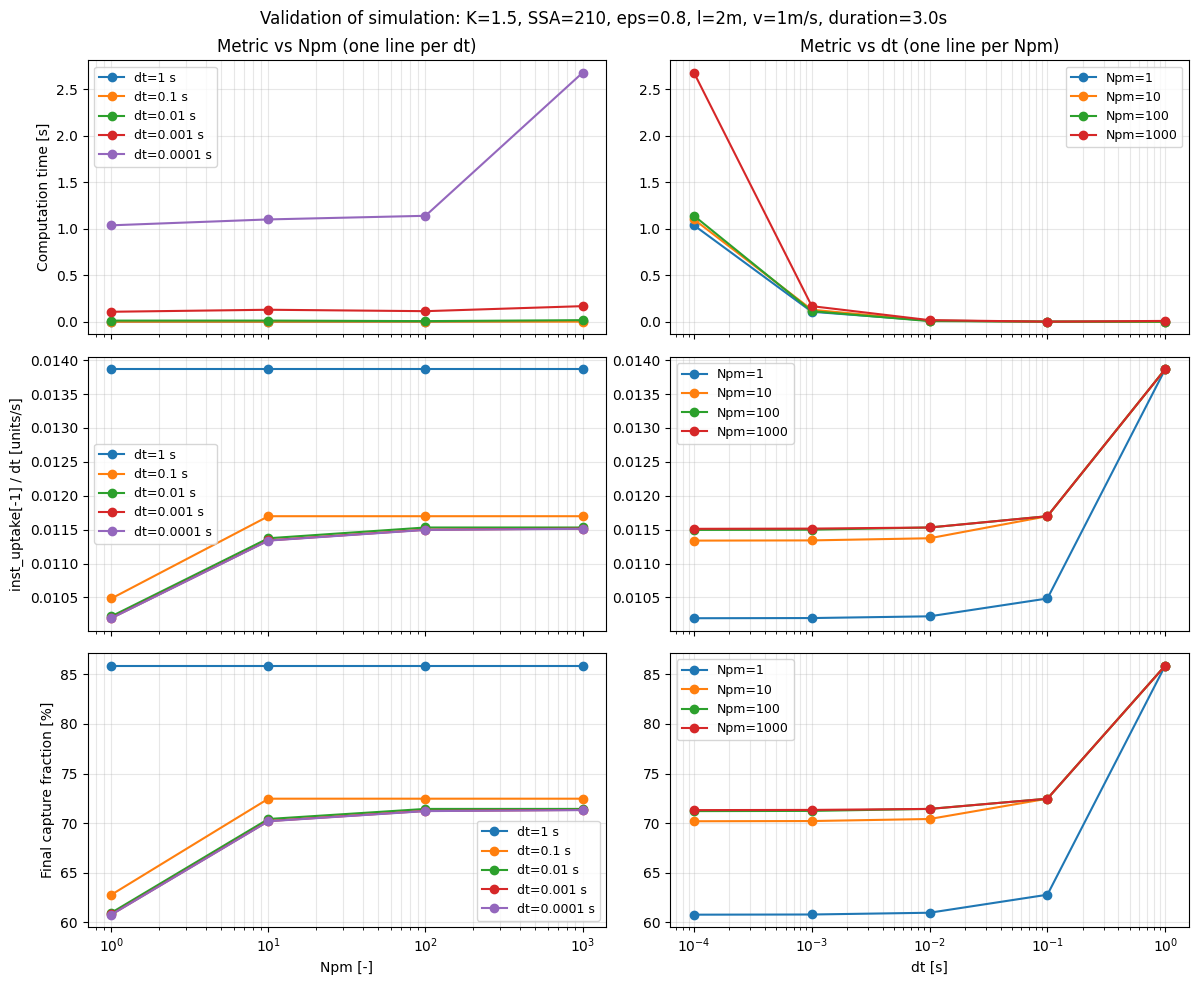

In [6]:


# --- metrics config (as in your code) ---
metrics = [
    ("calc_time_s", "Computation time [s]"),
    ("inst_uptake_last_over_dt", "inst_uptake[-1] / dt [units/s]"),
    ("cf_last_percent", "Final capture fraction [%]"),
]

# Deduplicate dt for legend/lines
unique_dt = []
for d in dt_list:
    if d not in unique_dt:
        unique_dt.append(d)
unique_Npm = Npm_list

# --- figure & axes ---
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 10),
    sharex='col',  # share within each column
)

# Column titles
axes[0, 0].set_title("Metric vs Npm (one line per dt)")
axes[0, 1].set_title("Metric vs dt (one line per Npm)")

# Formatters to avoid scientific notation on y by default
yfmt = ScalarFormatter()
yfmt.set_useOffset(False)
yfmt.set_scientific(False)

# ---- Left column: x = Npm, one line per dt ----
for row_idx, (mkey, mlabel) in enumerate(metrics):
    ax = axes[row_idx, 0]
    for d in unique_dt:
        sub = df[df["dt"] == d].sort_values("Npm")
        if len(sub) == 0:
            continue
        ax.plot(sub["Npm"], sub[mkey], marker="o", label=f"dt={d:g} s")
    ax.set_ylabel(mlabel)
    ax.grid(True, which="both", alpha=0.3)
    ax.set_xscale("log")  # Npm spans 1→1000
    ax.yaxis.set_major_formatter(yfmt)
    ax.legend(loc="best", fontsize=9)

# X label only on bottom-left
axes[-1, 0].set_xlabel("Npm [-]")

# ---- Right column: x = dt, one line per Npm ----
for row_idx, (mkey, mlabel) in enumerate(metrics):
    ax = axes[row_idx, 1]
    for npmi in unique_Npm:
        sub = df[df["Npm"] == npmi].sort_values("dt")
        if len(sub) == 0:
            continue
        ax.plot(sub["dt"], sub[mkey], marker="o", label=f"Npm={npmi}")
    ax.grid(True, which="both", alpha=0.3)
    ax.set_xscale("log")  # dt spans orders of magnitude
    ax.yaxis.set_major_formatter(yfmt)
    ax.legend(loc="best", fontsize=9)

# X label only on bottom-right
axes[-1, 1].set_xlabel("dt [s]")
fig.suptitle(f"Validation of simulation: K={K_initial}, SSA={SSA}, eps={eps}, l={l}m, v={v}m/s, duration={duration}s")

# Tidy layout
plt.tight_layout()
plt.savefig(path + ".png")
print("saved plot as: " + path + ".png")

plt.show()